In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

import utils

In [2]:
# patent_data = utils.load_patent_data('../data/processed/uspto.xlsx','cleaned_data')
patent_data = utils.load_patent_data('../data/patsnap_data.xlsx','sheet1')

In [3]:
patent_data.head(3)

,Number,Publication Number,Title,Legal Status & Events,Current Assignee,Application Date,IPC,Patent Valuation,Abstract,Abstract_English,Claims,Title_English,CPC
0,1,US6056237A,Sonotube compatible unmanned aerial vehicle an...,Non-payment,1281329 ALBERTA LTD.,1997-06-25,B64D1/02 | B64D1/00 | B64D33/02 | B64C39/00 | ...,-,The present invention is generally comprised o...,The present invention is generally comprised o...,I claim:_x000D_\n1. A sonotube compatible unma...,Sonotube compatible unmanned aerial vehicle an...,B64C3/40 | B64C5/12 | B64C39/024 | B64D1/02 | ...
1,2,US8511606B1,Unmanned aerial vehicle base station,Granted,THE BOEING COMPANY,2009-12-09,B64D41/00,"$ 56,000","A method and apparatus comprising a platform, ...","A method and apparatus comprising a platform, ...",1. An apparatus comprising:_x000D_\na platform...,Unmanned aerial vehicle base station,B64C39/028 | B64C39/024 | B64C2201/066 | B64C2...
2,3,US8948935B1,Providing a medical support device via an unma...,Granted | Transfer,WING AVIATION LLC,2013-01-02,G06Q10/00 | B64C39/02 | G16H40/67,"$ 79,000",Embodiments described herein may relate to an ...,Embodiments described herein may relate to an ...,1. An unmanned aerial vehicle (UAV) comprising...,Providing a medical support device via an unma...,A61B5/00 | A61B19/0264 | B64C39/024 | G06F19/3...


In [4]:
# patent_data['concatenated_text'] = patent_data['Title_English'] + ' ' + \
#                                    patent_data['Abstract_English']

In [5]:
# Extract the concatenated texts
patent_texts = patent_data['Title_English'].tolist()
# patent_texts = patent_data['concatenated_text'].tolist()

In [6]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [7]:
embeddings = model.encode(patent_texts)

In [8]:
# Optionally perform dimensionality reduction using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

In [9]:
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(embeddings)

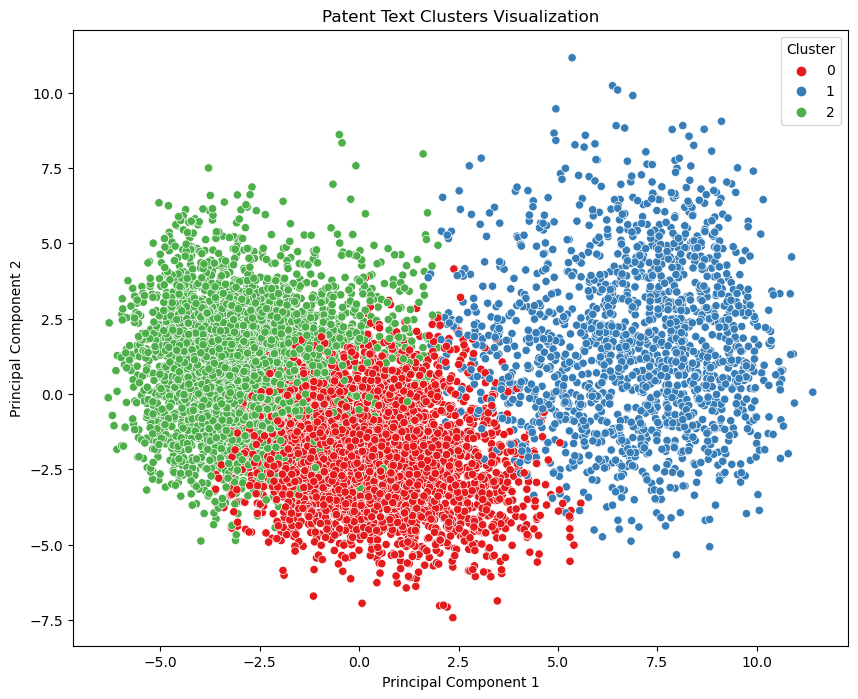

In [11]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=clusters, palette='Set1', legend='full')
plt.title('Patent Text Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [12]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(embeddings, clusters)
print(f"Silhouette Score: {silhouette_avg}")

inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

Silhouette Score: 0.05508716404438019
Inertia: 880971.125


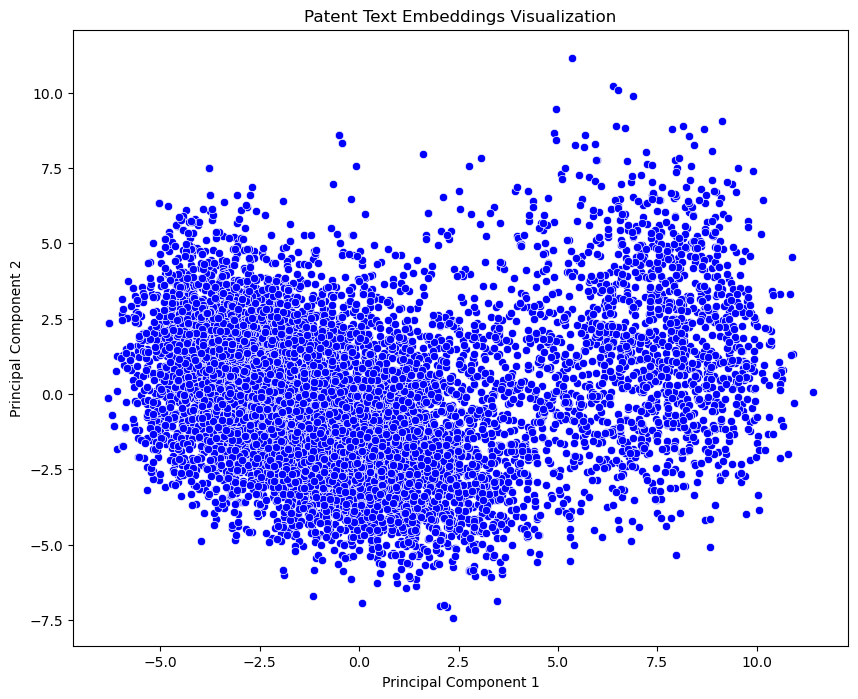

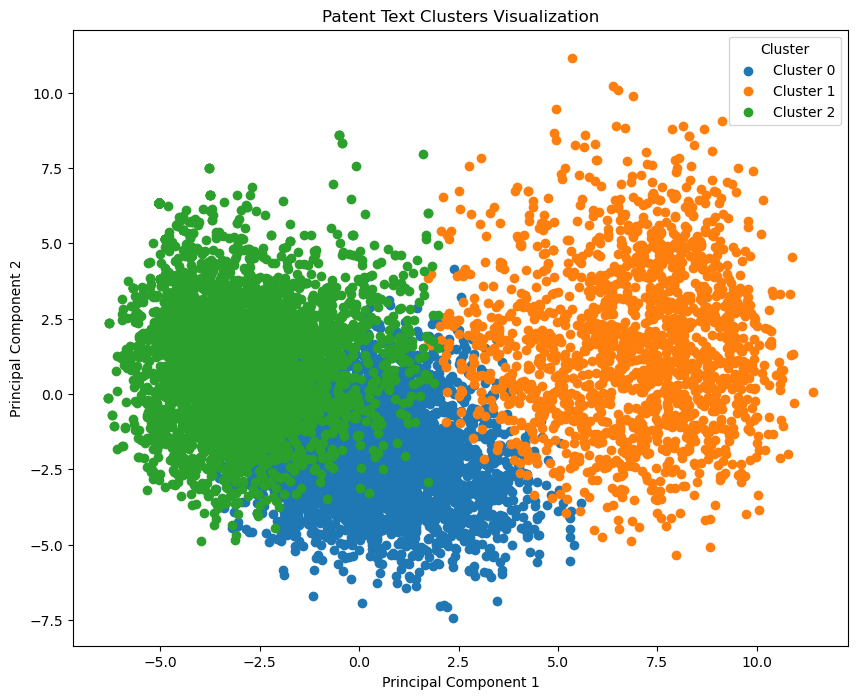

In [13]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], color='blue')
plt.title('Patent Text Embeddings Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

plt.figure(figsize=(10, 8))
for cluster_label in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embeddings_2d[cluster_indices, 0], embeddings_2d[cluster_indices, 1], label=f'Cluster {cluster_label}')
plt.title('Patent Text Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [14]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(embeddings, clusters)
print(f"Silhouette Score: {silhouette_avg}")

inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

Silhouette Score: 0.05508716404438019
Inertia: 880971.125


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

def interpret_clusters(patent_data, embeddings, clusters, top_n=10):
    cluster_centroids = []
    for cluster_label in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster_label)[0]
        cluster_embeddings = embeddings[cluster_indices]
        centroid = np.mean(cluster_embeddings, axis=0)
        cluster_centroids.append(centroid)

        # Extract patents' text for the current cluster
        cluster_texts = patent_data.iloc[cluster_indices]['Title_English'].tolist()
        
        # Perform top terms analysis using CountVectorizer
        vectorizer = CountVectorizer(stop_words='english')
        cluster_text_matrix = vectorizer.fit_transform(cluster_texts)
        cluster_word_counts = np.array(cluster_text_matrix.sum(axis=0)).squeeze()
        vocab = np.array(vectorizer.get_feature_names_out())
        top_terms_indices = cluster_word_counts.argsort()[::-1][:top_n]
        top_terms = vocab[top_terms_indices] 
        
        print(f"Cluster {cluster_label}:")
        print(f"Top Terms: {', '.join(top_terms)}")
        print("")

    return cluster_centroids

cluster_centroids = interpret_clusters(patent_data, embeddings, clusters)

Cluster 0:
Top Terms: aerial, unmanned, vehicle, method, based, device, control, inspection, detection, uav

Cluster 1:
Top Terms: method, based, device, detection, monitoring, power, line, control, vehicle, transmission

Cluster 2:
Top Terms: unmanned, aerial, vehicle, method, device, control, rotor, based, landing, multi

